In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from IMV_LSTM.networks import IMVFullLSTM

In [4]:
data1 = pd.read_csv("TS_datasets/sml2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("TS_datasets/sml2010/NEW-DATA-2.T15.txt", sep=' ')

In [5]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [6]:
data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [7]:
train_size = 3200
val_size = 400
depth = 10
batch_size = 128
prediction_horizon = 1

In [8]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [9]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [10]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [11]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [12]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [13]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [14]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [15]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [16]:
X_train.shape, y_train.shape

((3179, 10, 17), (3179,))

In [17]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [18]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [19]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [20]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [26]:
model = IMVFullLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
import time

Saving...
Iter:  0 train:  0.3672546275528404 val:  0.4808761122740021
Iter time:  3.8446547724306583
mse:  111.92105 mae:  9.777427


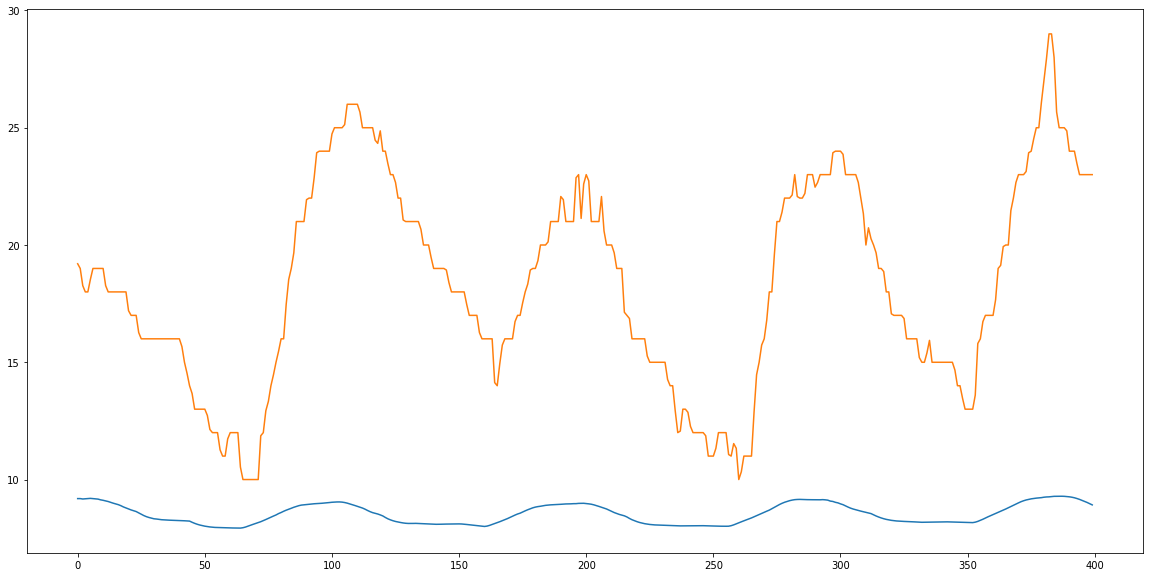

Saving...
Iter:  1 train:  0.2580854511206435 val:  0.09853997544827711
Iter time:  0.8868772592395544
Iter:  2 train:  0.11314042152461845 val:  0.10134709394265513
Iter time:  0.7365103056654334
Saving...
Iter:  3 train:  0.09533569635179404 val:  0.06382666404644323
Iter time:  0.8722335705533624
Saving...
Iter:  4 train:  0.08856586884610711 val:  0.056363052350646946
Iter time:  0.8778135161846876
Saving...
Iter:  5 train:  0.08070097512140612 val:  0.05474334692213776
Iter time:  0.8779027219861746
Iter:  6 train:  0.0743678448774704 val:  0.05943911691927242
Iter time:  0.7363692913204432
Iter:  7 train:  0.06420270663279735 val:  0.05595962287899644
Iter time:  0.7357287025079131
Iter:  8 train:  0.056636503967096685 val:  0.05615798009697402
Iter time:  0.7369575658813119
Saving...
Iter:  9 train:  0.05457792144733763 val:  0.05311254432460455
Iter time:  0.8765285117551684
Iter:  10 train:  0.053967404624314055 val:  0.05689088125467146
Iter time:  0.7412778967991471
mse:  1.

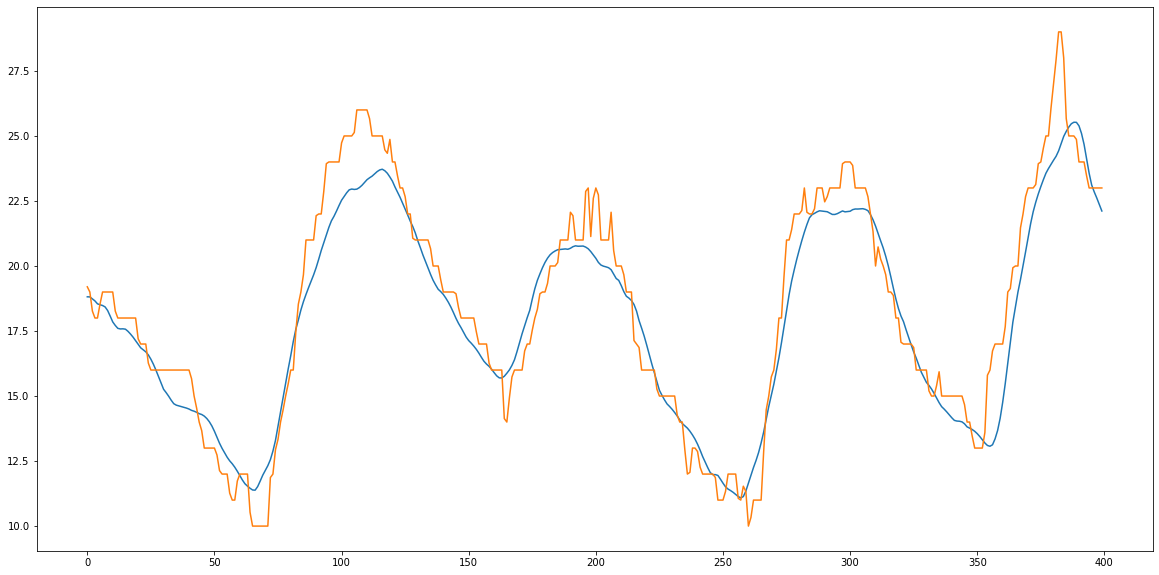

Iter:  11 train:  0.05342471954798917 val:  0.06082347991170749
Iter time:  0.7365779941901565
Saving...
Iter:  12 train:  0.05107102932519858 val:  0.04960407713138068
Iter time:  0.8732090219855309
Saving...
Iter:  13 train:  0.049814686518139445 val:  0.04937269454414451
Iter time:  0.8812772845849395
Iter:  14 train:  0.0504026879768273 val:  0.055127459946930475
Iter time:  0.7384184496477246
Iter:  15 train:  0.04960674708586771 val:  0.05090432365032423
Iter time:  0.7370867533609271
Iter:  16 train:  0.047698300802032766 val:  0.05419370984098072
Iter time:  0.7362776007503271
Saving...
Iter:  17 train:  0.04708622167416359 val:  0.048613626073500955
Iter time:  0.8781999703496695
Iter:  18 train:  0.04595229710964894 val:  0.05426625908317232
Iter time:  0.73800153657794
Iter:  19 train:  0.044735882511482215 val:  0.06249985456449753
Iter time:  0.7371869189664721
Iter:  20 train:  0.046838701714942775 val:  0.053236132674203594
Iter time:  0.7411909094080329
mse:  1.3716975 

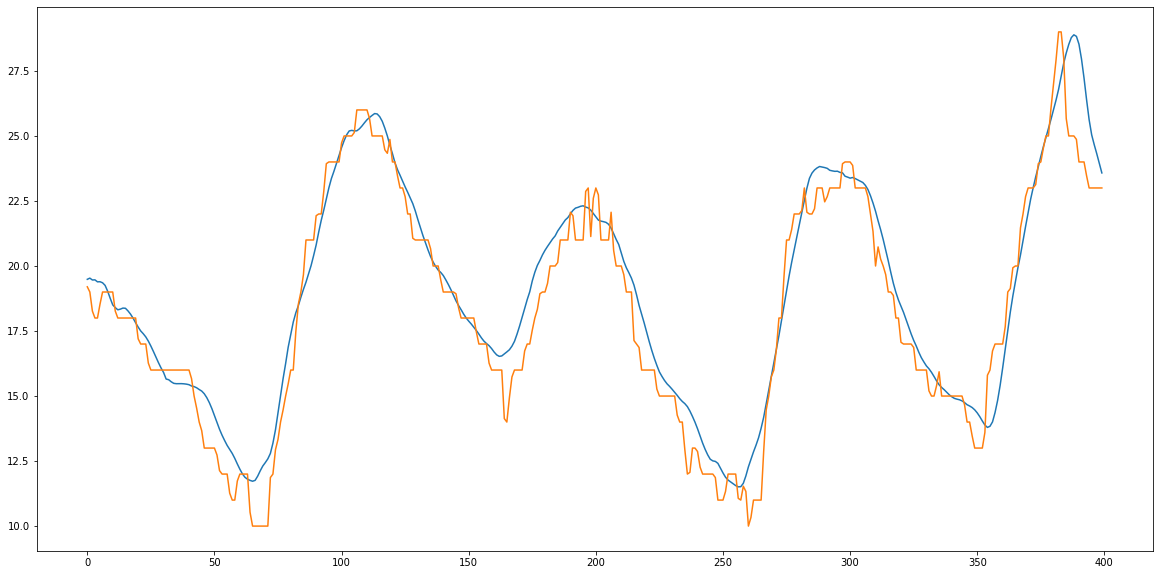

Iter:  21 train:  0.044767701854879924 val:  0.05202273387922908
Iter time:  0.7867783419787884
Iter:  22 train:  0.0458838597236587 val:  0.04865894572986307
Iter time:  0.737295719794929
Saving...
Iter:  23 train:  0.042075776718122834 val:  0.047661295608072085
Iter time:  0.8699467564001679
Iter:  24 train:  0.041033519030266564 val:  0.048705653521193104
Iter time:  0.7369498033076525
Saving...
Iter:  25 train:  0.039608428423018135 val:  0.045262970245091926
Iter time:  0.8762253159657121
Saving...
Iter:  26 train:  0.038283875112640635 val:  0.04376173670900401
Iter time:  0.8932243594899774
Saving...
Iter:  27 train:  0.03605638932662006 val:  0.043242544570730505
Iter time:  0.8695910004898906
Saving...
Iter:  28 train:  0.034993770955903454 val:  0.04222510877889418
Iter time:  0.8723992686718702
Iter:  29 train:  0.03627086161187816 val:  0.04490883720938109
Iter time:  0.7371217897161841
Saving...
Iter:  30 train:  0.034011709819012186 val:  0.04081048002874263
Iter time:  

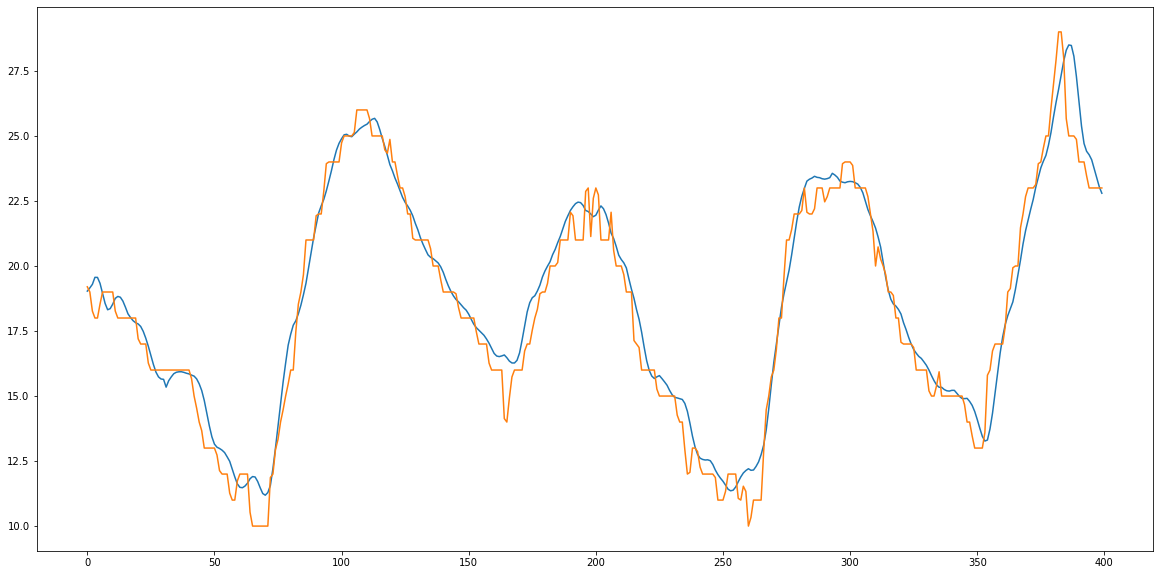

Iter:  31 train:  0.03859415966841576 val:  0.053899201851481754
Iter time:  0.7376288240775466
Iter:  32 train:  0.036745965732722645 val:  0.041168566702982946
Iter time:  0.7371053770184517
Saving...
Iter:  33 train:  0.034888875405346666 val:  0.040267588045394986
Iter time:  0.8726850776001811
Iter:  34 train:  0.033489127226639215 val:  0.0450175944840554
Iter time:  0.7379016075283289
Iter:  35 train:  0.03538421822572037 val:  0.04638015359296644
Iter time:  0.7359686931595206
Iter:  36 train:  0.03365911706335431 val:  0.04078921520706522
Iter time:  0.7362197702750564
Saving...
Iter:  37 train:  0.030477421303007218 val:  0.03771216529687234
Iter time:  0.8781855776906013
Iter:  38 train:  0.029688950305317777 val:  0.03844395843963167
Iter time:  0.7392558716237545
Iter:  39 train:  0.030570632902691366 val:  0.04310208700143377
Iter time:  0.7412340026348829
Iter:  40 train:  0.0325503668315532 val:  0.03842055048798463
Iter time:  0.7384844198822975
mse:  0.7144511 mae:  0

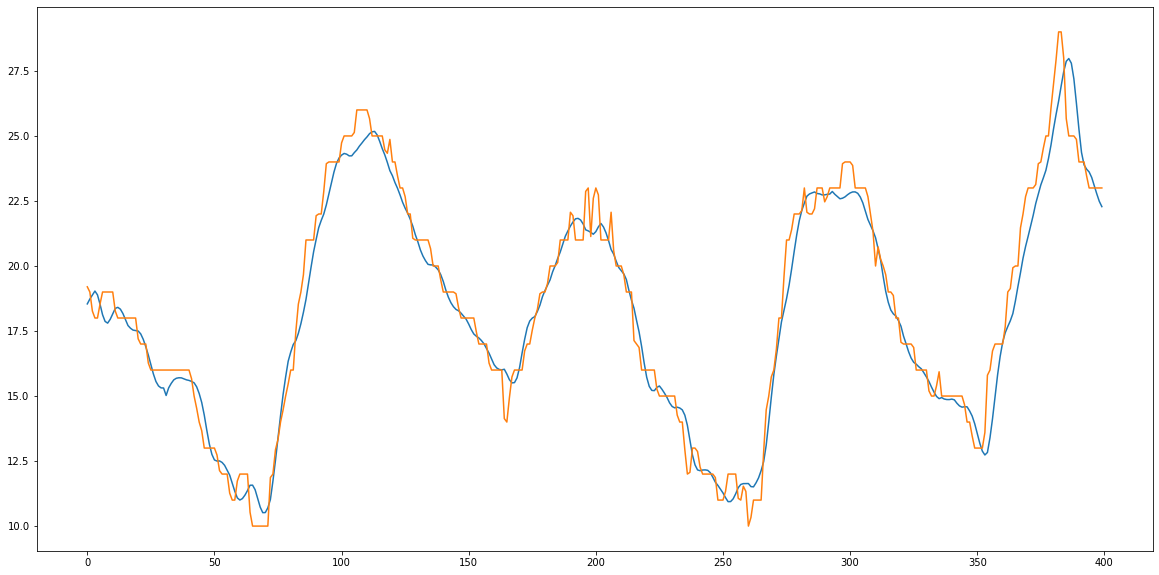

Saving...
Iter:  41 train:  0.029206133767291993 val:  0.03643905024682261
Iter time:  0.9390521422028542
Iter:  42 train:  0.029605545779871675 val:  0.04061717407334934
Iter time:  0.7367478525266051
Saving...
Iter:  43 train:  0.030706042697572954 val:  0.03618889477245694
Iter time:  0.8779192147776484
Saving...
Iter:  44 train:  0.028404158691937534 val:  0.03582487963282215
Iter time:  0.8783867321908474
Iter:  45 train:  0.02832702539170226 val:  0.03598097938736001
Iter time:  0.7366042239591479
Saving...
Iter:  46 train:  0.02918897718607471 val:  0.035276215434391515
Iter time:  0.8995065474882722
Iter:  47 train:  0.02881293943538087 val:  0.036282488655579294
Iter time:  0.7375895837321877
Iter:  48 train:  0.028189800138783708 val:  0.035333823922450706
Iter time:  0.7358271591365337
Saving...
Iter:  49 train:  0.02761483913039402 val:  0.03424138522399565
Iter time:  0.877192160114646
Saving...
Iter:  50 train:  0.02747778804276435 val:  0.03389096219759914
Iter time:  0.

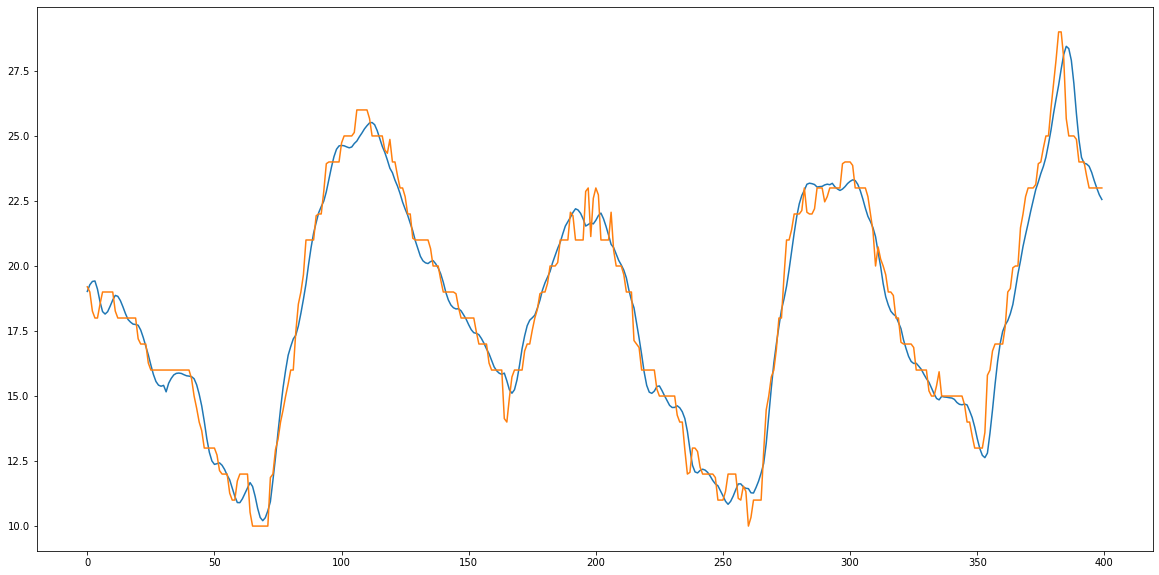

Iter:  51 train:  0.028293600509043396 val:  0.03775434837141637
Iter time:  0.7354893162846565
Iter:  52 train:  0.029188630247460056 val:  0.03462037082955929
Iter time:  0.7354205083101988
Iter:  53 train:  0.02743533308426388 val:  0.0351102581125315
Iter time:  0.7391415406018496
Iter:  54 train:  0.027715525891588277 val:  0.04199043846923592
Iter time:  0.7374036395922303
Iter:  55 train:  0.028727579139444646 val:  0.03477063839371884
Iter time:  0.7360528511926532
Saving...
Iter:  56 train:  0.026806112569525493 val:  0.033594492693387226
Iter time:  0.8707715049386024
Saving...
Iter:  57 train:  0.026518082785127187 val:  0.032919281817799705
Iter time:  0.8790014898404479
Iter:  58 train:  0.027480898829979384 val:  0.034122243429509966
Iter time:  0.7365821376442909
Saving...
Iter:  59 train:  0.029039300419650672 val:  0.032919124236015715
Iter time:  0.8785740341991186
Saving...
Iter:  60 train:  0.025648231463692543 val:  0.03211926022696097
Iter time:  0.879247681237757

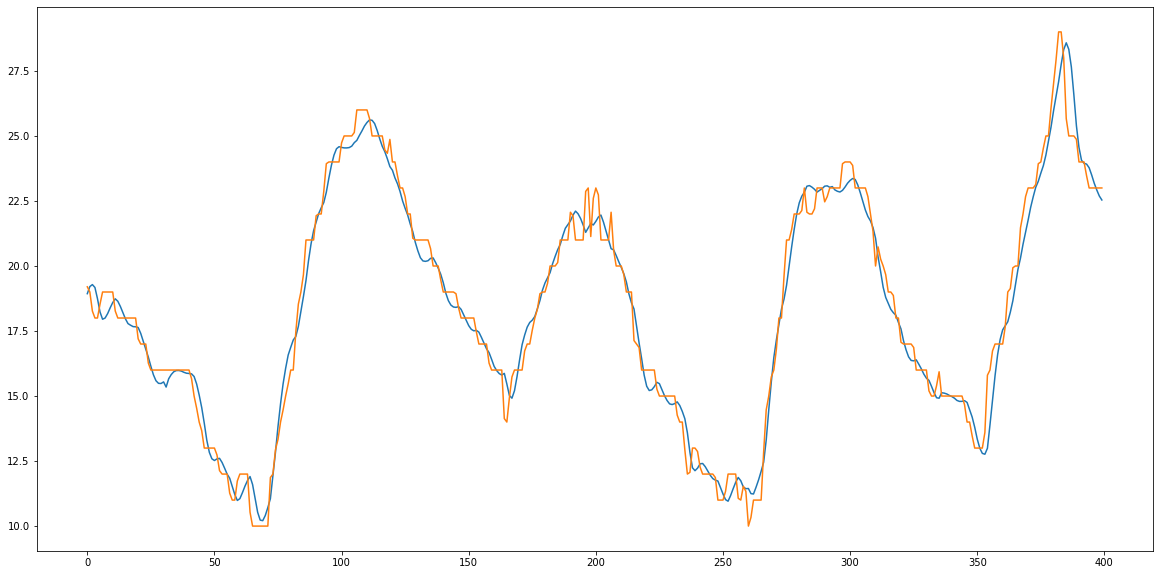

Iter:  61 train:  0.024839510799285217 val:  0.03316291646471224
Iter time:  0.7357352143153548
Iter:  62 train:  0.02701017367758519 val:  0.03260054163565124
Iter time:  0.7356945248320699
Saving...
Iter:  63 train:  0.024981757259987702 val:  0.031346213227330444
Iter time:  0.8736710604280233
Iter:  64 train:  0.026547323707849558 val:  0.0440142358067088
Iter time:  0.7379687633365393
Iter:  65 train:  0.027014009598127352 val:  0.03164225944959939
Iter time:  0.7363520702347159
Saving...
Iter:  66 train:  0.025553750556811715 val:  0.031092619372184178
Iter time:  0.8774542799219489
Saving...
Iter:  67 train:  0.024171346586684853 val:  0.030877831529014722
Iter time:  0.8791840160265565
Iter:  68 train:  0.02761721563391381 val:  0.040234178246322576
Iter time:  0.7364856814965606
Iter:  69 train:  0.026600844969257867 val:  0.0311933244916747
Iter time:  0.7357416152954102
Iter:  70 train:  0.026263500280645467 val:  0.03370461218934578
Iter time:  0.7363931331783533
mse:  0.54

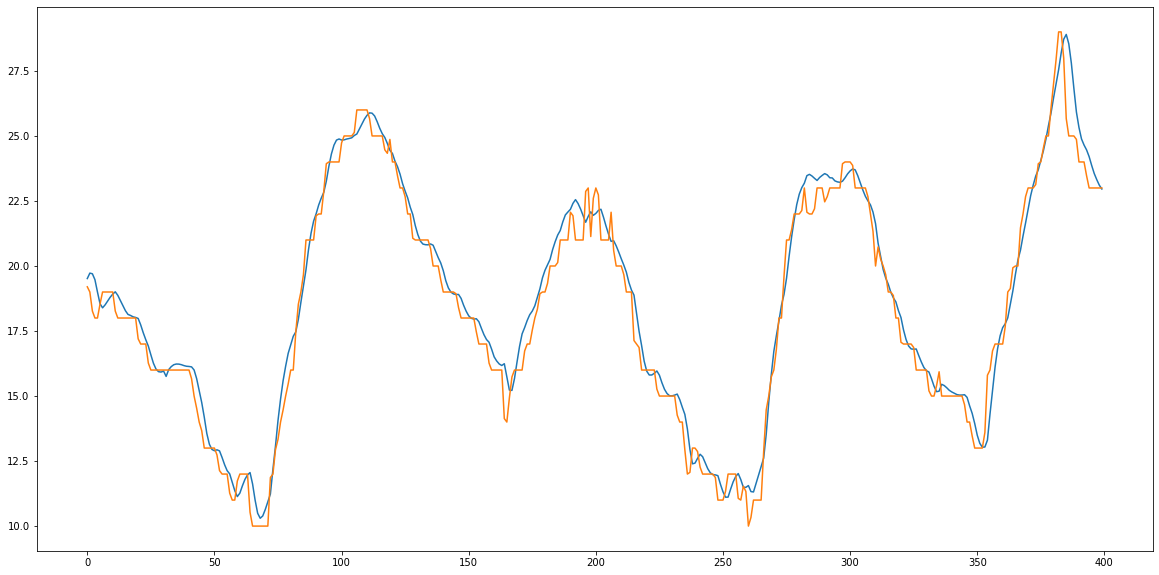

Saving...
Iter:  71 train:  0.024132421730127793 val:  0.030447762548091624
Iter time:  0.8793380446732044
Saving...
Iter:  72 train:  0.023042381810758857 val:  0.02999858246871625
Iter time:  0.8814923306927085
Iter:  73 train:  0.023771997105909253 val:  0.03053431700360439
Iter time:  0.738946151919663
Iter:  74 train:  0.023658428226181277 val:  0.030802037595042606
Iter time:  0.7368775308132172
Iter:  75 train:  0.025475593724202564 val:  0.03642380008474491
Iter time:  0.7372877271845937
Iter:  76 train:  0.024894513269235436 val:  0.0349257003899293
Iter time:  0.7370482869446278
Saving...
Iter:  77 train:  0.02305901296112739 val:  0.029154126328885473
Iter time:  0.8799881273880601
Iter:  78 train:  0.025117948497400996 val:  0.029680708058065167
Iter time:  0.7393499566242099
Iter:  79 train:  0.025351061521796267 val:  0.03252015700325319
Iter time:  0.7376931356266141
Iter:  80 train:  0.02343709720973016 val:  0.02980031753266258
Iter time:  0.7385077243670821
mse:  0.42

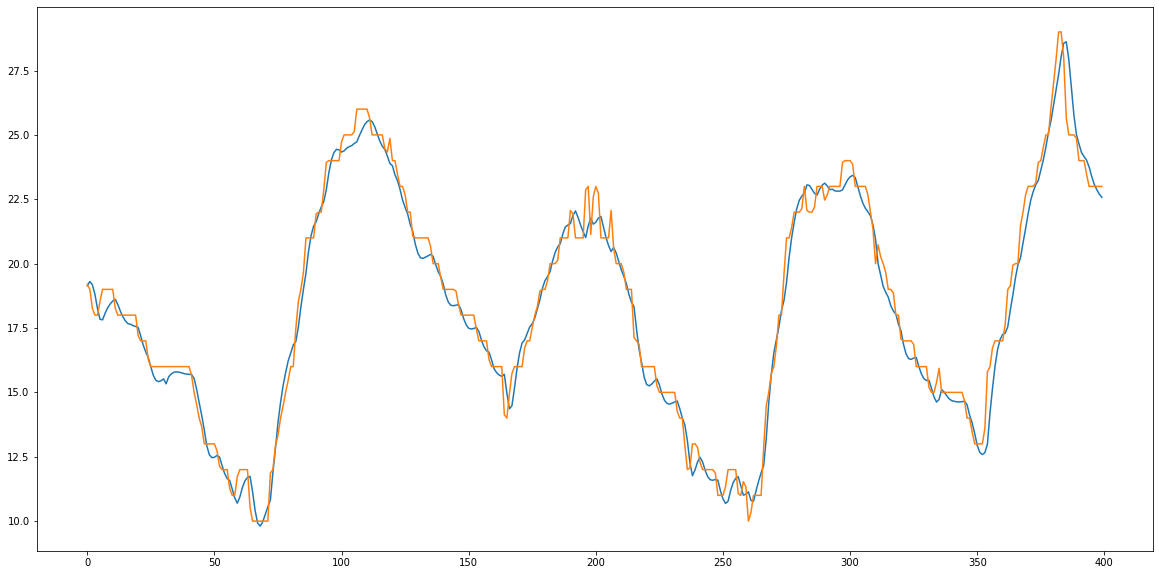

Iter:  81 train:  0.022711756395838847 val:  0.033132703656820826
Iter time:  0.7364469720050693
Iter:  82 train:  0.02342248563018064 val:  0.029602097344116084
Iter time:  0.7358953915536404
Iter:  83 train:  0.022327305177808822 val:  0.029830219699311607
Iter time:  0.7362405536696315
Iter:  84 train:  0.022004518801835692 val:  0.02993797449923519
Iter time:  0.7364260731264949
Iter:  85 train:  0.023401783807122073 val:  0.03018813058007465
Iter time:  0.7359310220927
Saving...
Iter:  86 train:  0.022396564897733808 val:  0.027918630191829004
Iter time:  0.872069981880486
Iter:  87 train:  0.02298975353711691 val:  0.029155158287208098
Iter time:  0.7378504211083055
Saving...
Iter:  88 train:  0.021573785646263877 val:  0.027548001238756996
Iter time:  0.8758671637624502
Iter:  89 train:  0.023271118779748533 val:  0.031149838834163102
Iter time:  0.7369867218658328
Iter:  90 train:  0.022118188059132023 val:  0.028988012300258152
Iter time:  0.7354597086086869
mse:  0.4067074 ma

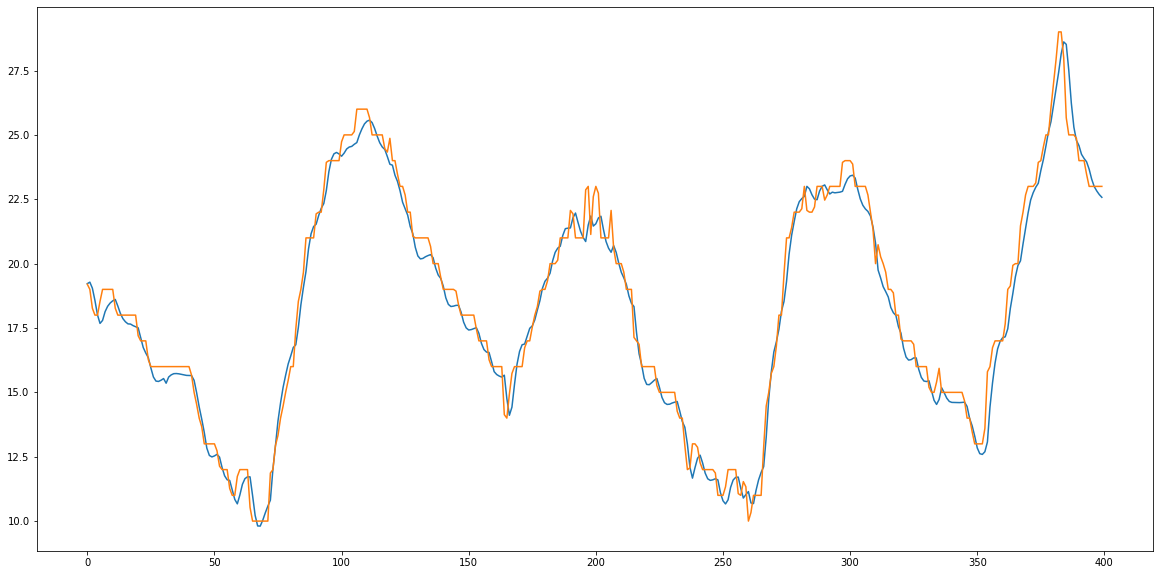

Iter:  91 train:  0.022341038932869046 val:  0.030909320545939197
Iter time:  0.7368620093911886
Iter:  92 train:  0.02370036625363361 val:  0.02907812627754434
Iter time:  0.7342986911535263
Saving...
Iter:  93 train:  0.022053027338437284 val:  0.02737522629639965
Iter time:  0.8679083017632365
Iter:  94 train:  0.022550051676663817 val:  0.02744019139135918
Iter time:  0.7373185968026519
Iter:  95 train:  0.021747769954714814 val:  0.033856508849502844
Iter time:  0.7361336853355169
Iter:  96 train:  0.02563890500538019 val:  0.03392567408637568
Iter time:  0.7352371169254184
Iter:  97 train:  0.02481419802923736 val:  0.03212110176779865
Iter time:  0.7478030910715461
Saving...
Iter:  98 train:  0.022413245491243464 val:  0.027279867411948308
Iter time:  0.8683410612866282
Iter:  99 train:  0.022284537629732464 val:  0.03403108855674218
Iter time:  0.73772843927145
Saving...
Iter:  100 train:  0.02161500368146267 val:  0.026824077466117965
Iter time:  0.8771713199093938
mse:  0.348

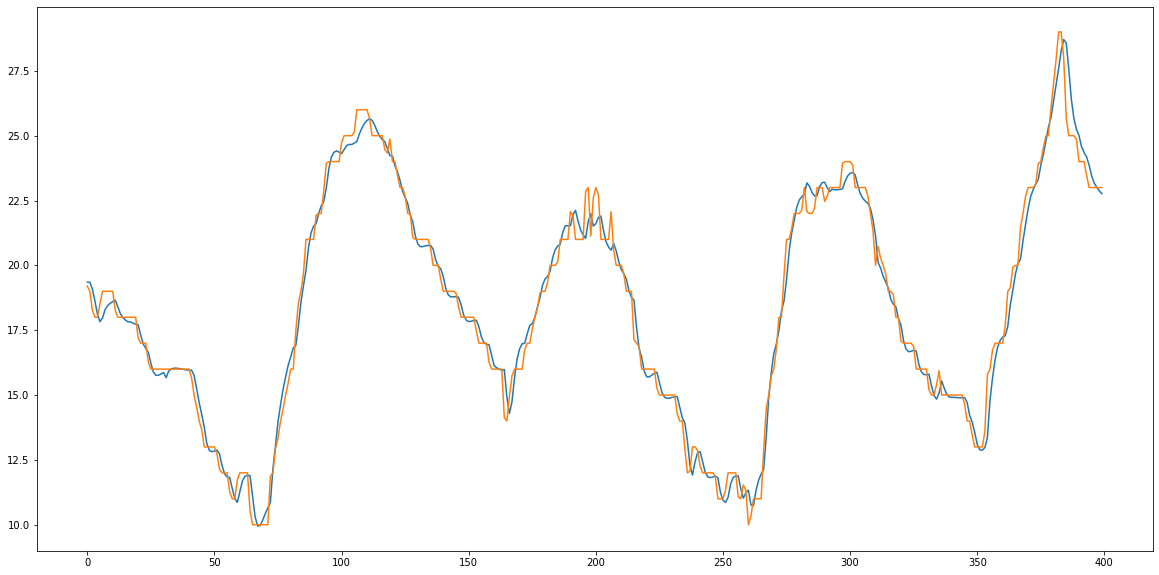

Iter:  101 train:  0.020903059016580086 val:  0.028231225148359587
Iter time:  0.7359663555398583
Iter:  102 train:  0.020775258703883123 val:  0.0272515030075101
Iter time:  0.7354669738560915
Iter:  103 train:  0.02071680332837392 val:  0.03760801878470038
Iter time:  0.7393839498981833
Iter:  104 train:  0.025055353874416906 val:  0.028084808182328308
Iter time:  0.735793836414814
Saving...
Iter:  105 train:  0.021517251525059043 val:  0.0264191872390332
Iter time:  0.8678271640092134
Iter:  106 train:  0.0214296616014206 val:  0.030627897752545048
Iter time:  0.7366495225578547
Iter:  107 train:  0.021357062720507823 val:  0.031016560157255086
Iter time:  0.735607361420989
Iter:  108 train:  0.020820002697991478 val:  0.026445587567401927
Iter time:  0.7347795171663165
Iter:  109 train:  0.020319044696328222 val:  0.027220784844029972
Iter time:  0.7346689384430647
Iter:  110 train:  0.020514690985726832 val:  0.028753870374410764
Iter time:  0.7346771033480763
mse:  0.4001639 mae:

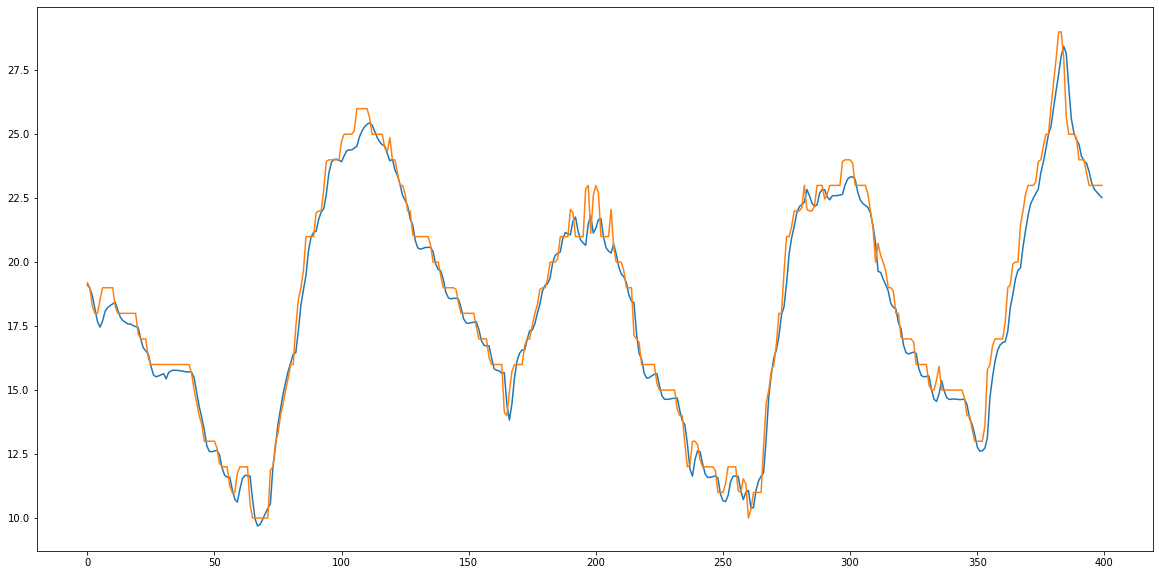

Saving...
Iter:  111 train:  0.020539750830616352 val:  0.02580450077015309
Iter time:  0.8821962457150221
Saving...
Iter:  112 train:  0.019862928789974154 val:  0.025422272033146655
Iter time:  0.8728301133960485
Iter:  113 train:  0.02073801441377604 val:  0.026445967639375505
Iter time:  0.7360991779714823
Iter:  114 train:  0.020115276296638746 val:  0.027428368529103214
Iter time:  0.7341135526075959
Iter:  115 train:  0.02067264166510512 val:  0.02613843624975361
Iter time:  0.7333418168127537
Iter:  116 train:  0.021111777225691658 val:  0.02595202463000274
Iter time:  0.7341552916914225
Iter:  117 train:  0.02083973866313732 val:  0.025743410851290636
Iter time:  0.7344350712373853
Saving...
Iter:  118 train:  0.019697904286555427 val:  0.025185846058494752
Iter time:  0.8713849037885666
Iter:  119 train:  0.020227784393363965 val:  0.026820622117621953
Iter time:  0.7360224258154631
Iter:  120 train:  0.02154255174325955 val:  0.027528118603604178
Iter time:  0.73322453349828

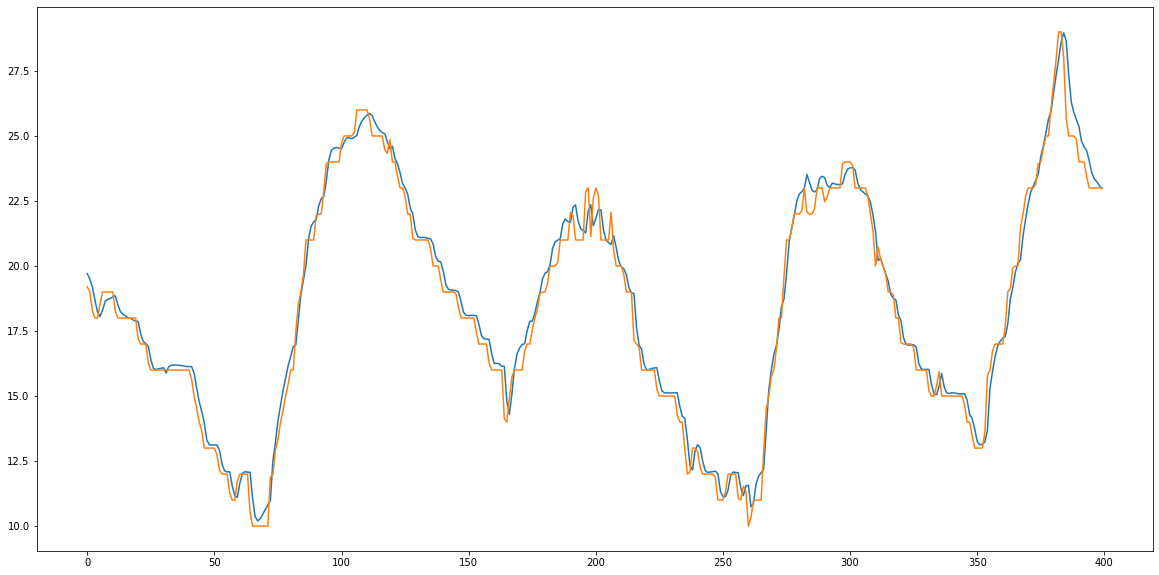

Saving...
Iter:  121 train:  0.019202938544636606 val:  0.02484863098348415
Iter time:  0.8818708024919033
Iter:  122 train:  0.019340884928904952 val:  0.025617075220235996
Iter time:  0.7351340372115374
Iter:  123 train:  0.019085780634691983 val:  0.026391309194859793
Iter time:  0.73463393189013
Saving...
Iter:  124 train:  0.02013806977477933 val:  0.024842428046269422
Iter time:  0.8728924747556448
Iter:  125 train:  0.018981938981305107 val:  0.028777387657302908
Iter time:  0.7355148158967495
Iter:  126 train:  0.019997818182984423 val:  0.02581416687421015
Iter time:  0.7354277735576034
Saving...
Iter:  127 train:  0.01907235129291981 val:  0.024488491854885483
Iter time:  0.8724296167492867
Iter:  128 train:  0.02089694467121806 val:  0.026650975466608655
Iter time:  0.7357652466744184
Iter:  129 train:  0.01975065149861949 val:  0.02633211576088604
Iter time:  0.7346297493204474
Iter:  130 train:  0.019028132897453053 val:  0.02479115317776918
Iter time:  0.7346653612330556


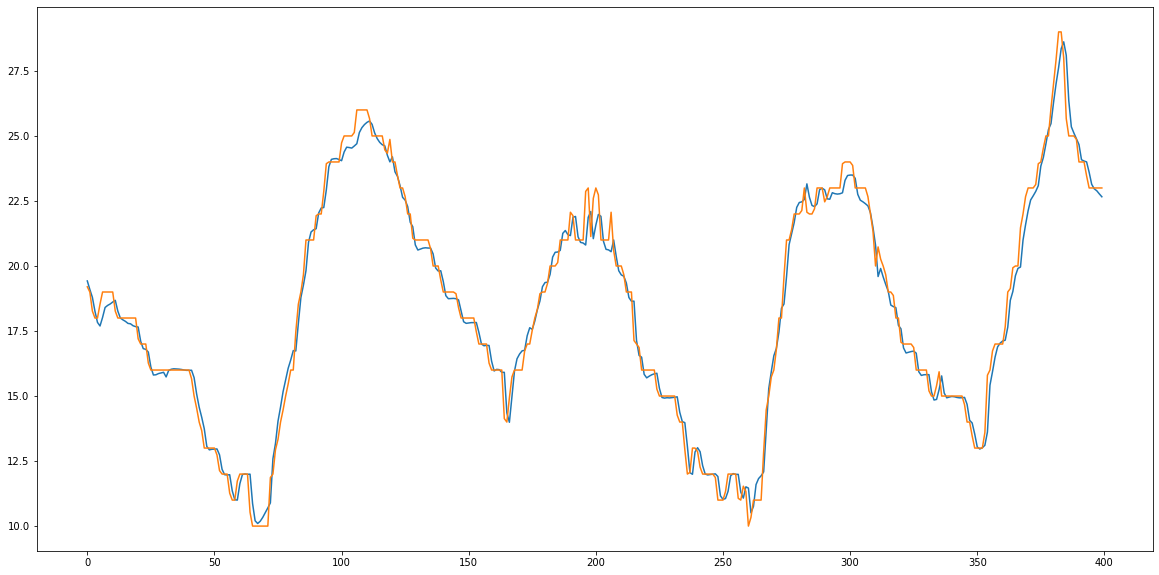

Iter:  131 train:  0.020819089864754562 val:  0.026758295597810927
Iter time:  0.7336646150797606
Iter:  132 train:  0.01965602948557047 val:  0.026394072354358308
Iter time:  0.7337024360895157
Iter:  133 train:  0.01934624751291889 val:  0.02522605602385655
Iter time:  0.7346080346032977
Iter:  134 train:  0.018871792788418554 val:  0.027049097721442893
Iter time:  0.73378936201334
Saving...
Iter:  135 train:  0.018904029997595734 val:  0.024252329608304958
Iter time:  0.8717453489080071
Iter:  136 train:  0.01907140445537097 val:  0.02957271919982229
Iter time:  0.7347539896145463
Iter:  137 train:  0.019132669197234612 val:  0.024564082041052558
Iter time:  0.7340502263978124
Iter:  138 train:  0.01964378244862621 val:  0.024810127446496376
Iter time:  0.7338588470593095
Iter:  139 train:  0.018677058011806514 val:  0.026973945067577314
Iter time:  0.7338167428970337
Iter:  140 train:  0.01973189095423037 val:  0.02664813440479583
Iter time:  0.7341323355212808
mse:  0.34369943 mae

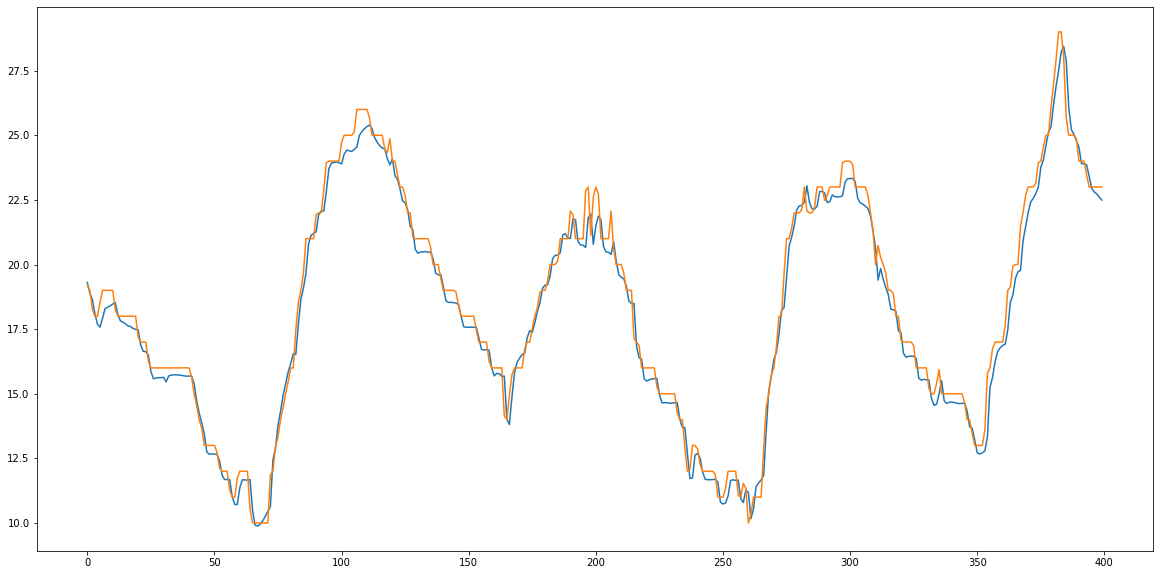

Iter:  141 train:  0.020000005994081572 val:  0.026393956265489276
Iter time:  0.734438736923039
Iter:  142 train:  0.018878072817267628 val:  0.02458458988246833
Iter time:  0.7349298540502787
Saving...
Iter:  143 train:  0.01892514002444081 val:  0.02385334161913443
Iter time:  0.8721395963802934
Iter:  144 train:  0.018861211440202568 val:  0.024330798834263728
Iter time:  0.7354887761175632
Iter:  145 train:  0.01872474733572926 val:  0.024958081697689795
Iter time:  0.7339958241209388
Saving...
Iter:  146 train:  0.01865120495353191 val:  0.023735308251795584
Iter time:  0.8787632919847965
Iter:  147 train:  0.018328794637724053 val:  0.02393207661854148
Iter time:  0.7357687158510089
Iter:  148 train:  0.01844858065281053 val:  0.02520686843807076
Iter time:  0.7339244810864329
Iter:  149 train:  0.020001862656885996 val:  0.024290703590758654
Iter time:  0.7337914984673262
Iter:  150 train:  0.018654033610026932 val:  0.02507573851701101
Iter time:  0.7345707640051842
mse:  0.30

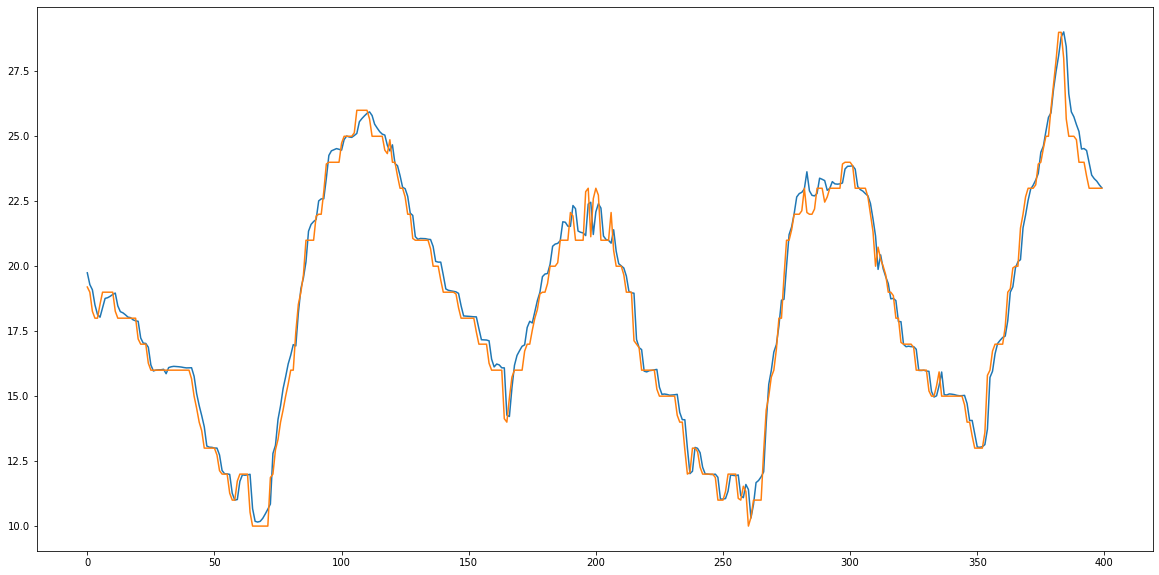

Iter:  151 train:  0.01848258441595114 val:  0.02375543129141725
Iter time:  0.7945358986034989
Iter:  152 train:  0.01946107660800207 val:  0.0315874089314156
Iter time:  0.7348745819181204
Iter:  153 train:  0.021115377774822818 val:  0.024032461595934158
Iter time:  0.7348778545856476
Iter:  154 train:  0.018178823811923175 val:  0.026728927551986675
Iter time:  0.7352519510313869
Iter:  155 train:  0.02011027267639206 val:  0.0293282572830176
Iter time:  0.7348634777590632
Saving...
Iter:  156 train:  0.019219169355717054 val:  0.023392482777598915
Iter time:  0.8718376066535711
Iter:  157 train:  0.01798378052911161 val:  0.02351312981719097
Iter time:  0.7348906807601452
Saving...
Iter:  158 train:  0.017995596326836984 val:  0.023250013023771464
Iter time:  0.869208037853241
Iter:  159 train:  0.019632464613175617 val:  0.023601249827549155
Iter time:  0.7374497950077057
Iter:  160 train:  0.018079725262948144 val:  0.02925808933958524
Iter time:  0.7353973770514131
mse:  0.4143

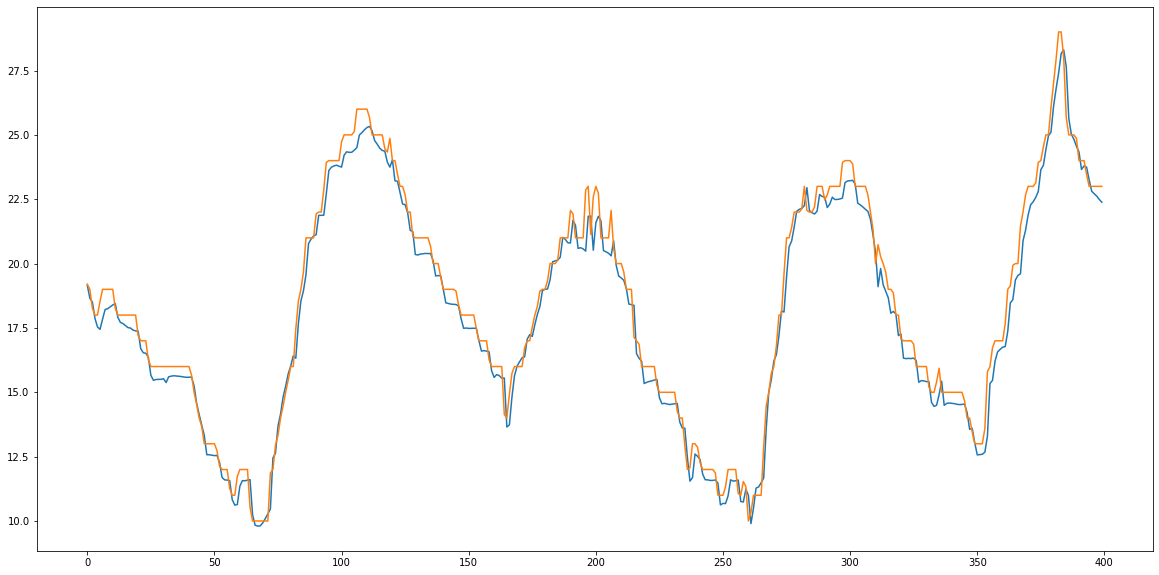

Iter:  161 train:  0.01835507943154883 val:  0.024058877189194194
Iter time:  0.73416009824723
Iter:  162 train:  0.017733562736391206 val:  0.02444897334782754
Iter time:  0.7352914465591311
Iter:  163 train:  0.017950825285734575 val:  0.02368139689605193
Iter time:  0.7349176956340671
Iter:  164 train:  0.017799940824261236 val:  0.023412970979187563
Iter time:  0.7355953212827444
Saving...
Iter:  165 train:  0.017699418700170458 val:  0.023158361431339054
Iter time:  0.8776964507997036
Iter:  166 train:  0.019025174100984976 val:  0.024938805757482908
Iter time:  0.7369767874479294
Iter:  167 train:  0.01827000312134473 val:  0.025485209621585687
Iter time:  0.7367582246661186
Iter:  168 train:  0.018399992886312624 val:  0.023617439649291444
Iter time:  0.7363124890252948
Saving...
Iter:  169 train:  0.017625779423813496 val:  0.022980042515066204
Iter time:  0.8733309404924512
Iter:  170 train:  0.019305525110279446 val:  0.02380038546294627
Iter time:  0.7369075389578938
mse:  0

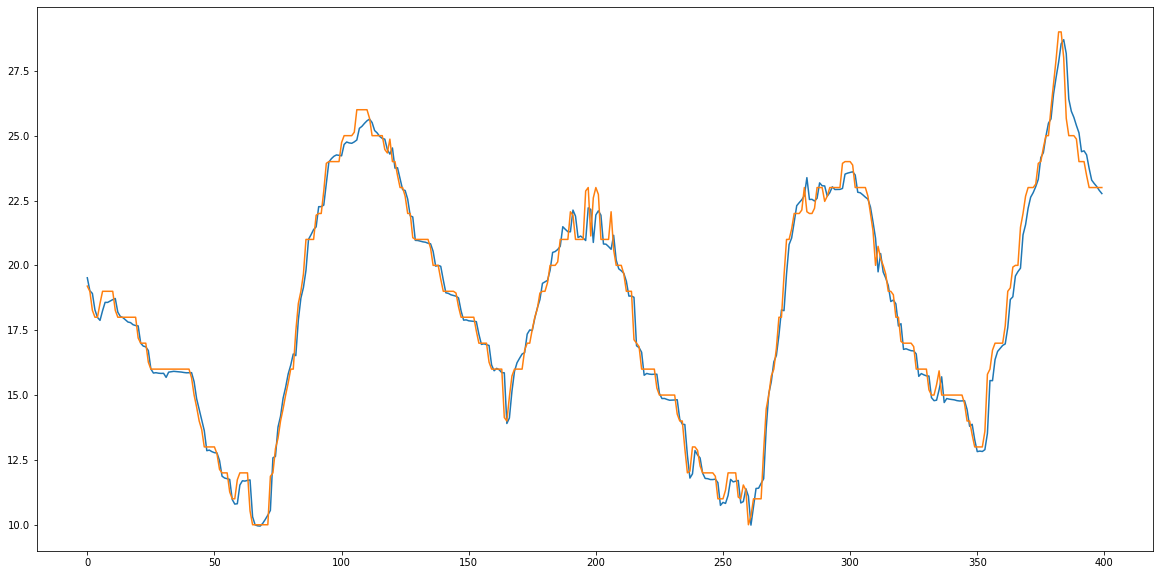

Iter:  171 train:  0.018157437696309158 val:  0.026499907862094295
Iter time:  0.736000937409699
Iter:  172 train:  0.018953126868168805 val:  0.023290576170928105
Iter time:  0.7361455513164401
Iter:  173 train:  0.01824790773342989 val:  0.02308930112730019
Iter time:  0.7352839168161154
Iter:  174 train:  0.018848932170842835 val:  0.02323745571182785
Iter time:  0.7356141740456223
Iter:  175 train:  0.0178972807966647 val:  0.024336535192347658
Iter time:  0.7360754907131195
Iter:  176 train:  0.017935701087335342 val:  0.02307523078145656
Iter time:  0.7355546075850725
Iter:  177 train:  0.018349009594980703 val:  0.023238506746953415
Iter time:  0.7354133063927293
Iter:  178 train:  0.01843599674013879 val:  0.023059759034153644
Iter time:  0.7355643771588802
Iter:  179 train:  0.019930661093906524 val:  0.023547272808085055
Iter time:  0.7364515867084265
Iter:  180 train:  0.01948447512252948 val:  0.02697443387556778
Iter time:  0.7353208009153605
mse:  0.35216805 mae:  0.46877

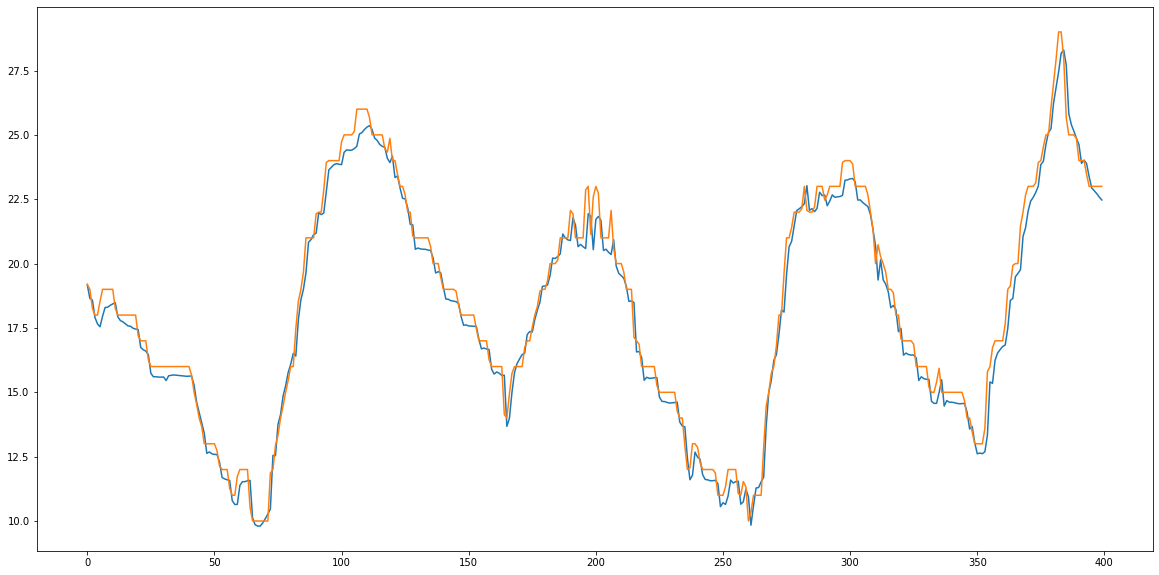

Iter:  181 train:  0.01897377408015499 val:  0.02373366569836629
Iter time:  0.7359017636626959
Iter:  182 train:  0.01829862828013631 val:  0.02557104082917605
Iter time:  0.7354165613651276
Iter:  183 train:  0.0186449862193494 val:  0.02394117959482086
Iter time:  0.7360241301357746
Iter:  184 train:  0.018443891328716478 val:  0.023784527017418074
Iter time:  0.7344732461497188
Iter:  185 train:  0.017640041433165013 val:  0.02676052772361699
Iter time:  0.7364375442266464
Iter:  186 train:  0.01838974180212505 val:  0.023174859549247005
Iter time:  0.736391800455749
Saving...
Iter:  187 train:  0.017572678724028883 val:  0.022933297518910958
Iter time:  0.8714505219832063
Iter:  188 train:  0.018091839752647033 val:  0.024570169137618343
Iter time:  0.7377398982644081
Iter:  189 train:  0.019460531087612327 val:  0.023215175607675605
Iter time:  0.7352297576144338
Iter:  190 train:  0.017761263202374363 val:  0.023517402010688224
Iter time:  0.7357553401961923
mse:  0.26768494 mae

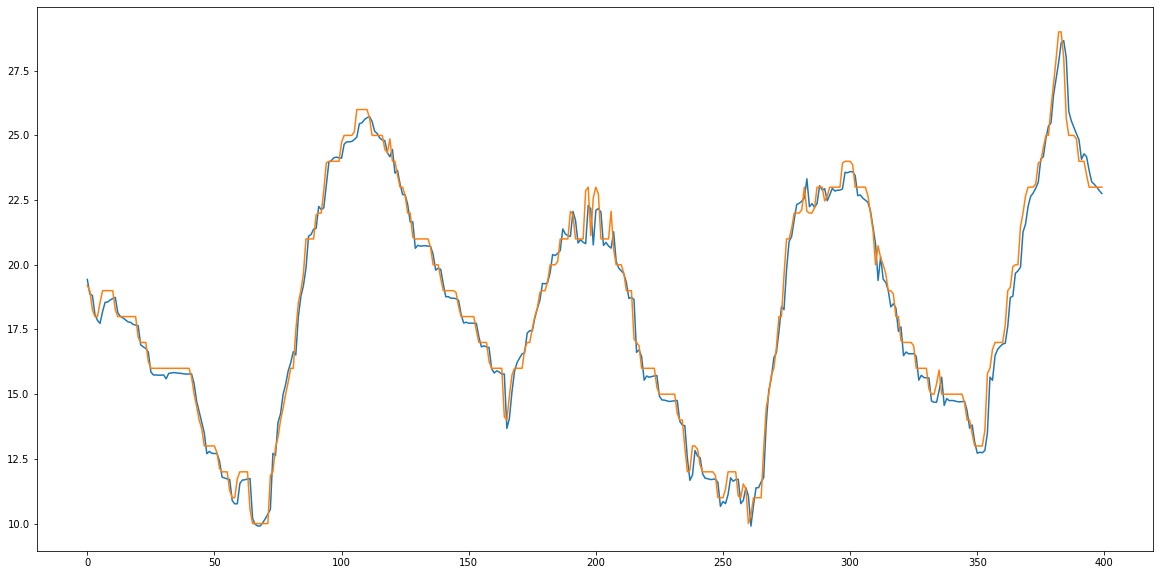

Iter:  191 train:  0.01899057820370954 val:  0.02681193203980331
Iter time:  0.7355781327933073
Iter:  192 train:  0.018926854487289434 val:  0.023411133757382654
Iter time:  0.7357897693291306
Iter:  193 train:  0.017853028821230816 val:  0.023360766426001198
Iter time:  0.7352685481309891
Iter:  194 train:  0.018142069559451676 val:  0.024747736292237334
Iter time:  0.7366528110578656
Iter:  195 train:  0.018241479494484028 val:  0.024670408646226296
Iter time:  0.7375555858016014
Iter:  196 train:  0.01739404862082748 val:  0.023003596549427893
Iter time:  0.7359691290184855
Iter:  197 train:  0.017969878101371514 val:  0.02302562645339925
Iter time:  0.7352275773882866
Iter:  198 train:  0.017783505283381296 val:  0.025933464767634046
Iter time:  0.7372769173234701
Iter:  199 train:  0.01803663559720638 val:  0.024347182698282944
Iter time:  0.7362054921686649
Iter:  200 train:  0.018220504019556497 val:  0.023650444759363964
Iter time:  0.7392830355092883
mse:  0.2707222 mae:  0.3

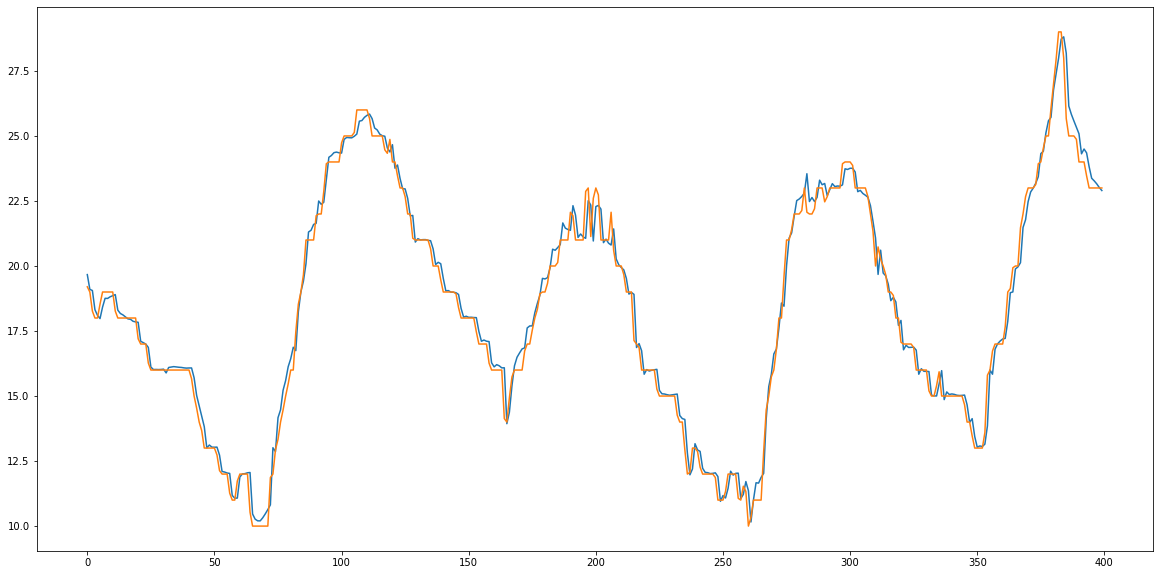

Iter:  201 train:  0.01837650706876081 val:  0.023798962926502416
Iter time:  0.7490444323047996
Iter:  202 train:  0.017834480149095916 val:  0.023017289783385696
Iter time:  0.7494896333664656
Saving...
Iter:  203 train:  0.017640092347688624 val:  0.022828779519298112
Iter time:  0.9600968724116683
Iter:  204 train:  0.01786465095677146 val:  0.02387859118484803
Iter time:  0.7552320240065455
Saving...
Iter:  205 train:  0.017474719514960435 val:  0.022734567094102733
Iter time:  0.883811118081212
Iter:  206 train:  0.01738389078754705 val:  0.024510795929243906
Iter time:  0.7403425863012671
Iter:  207 train:  0.018293099745435318 val:  0.023242805576921714
Iter time:  0.7394729144871235
Iter:  208 train:  0.018032112537396745 val:  0.023409307729911878
Iter time:  0.7388547426089644
Iter:  209 train:  0.017373834616965955 val:  0.022976021637398866
Iter time:  0.7589053837582469
Iter:  210 train:  0.017604428432047275 val:  0.022903467390541082
Iter time:  0.7356791775673628
mse: 

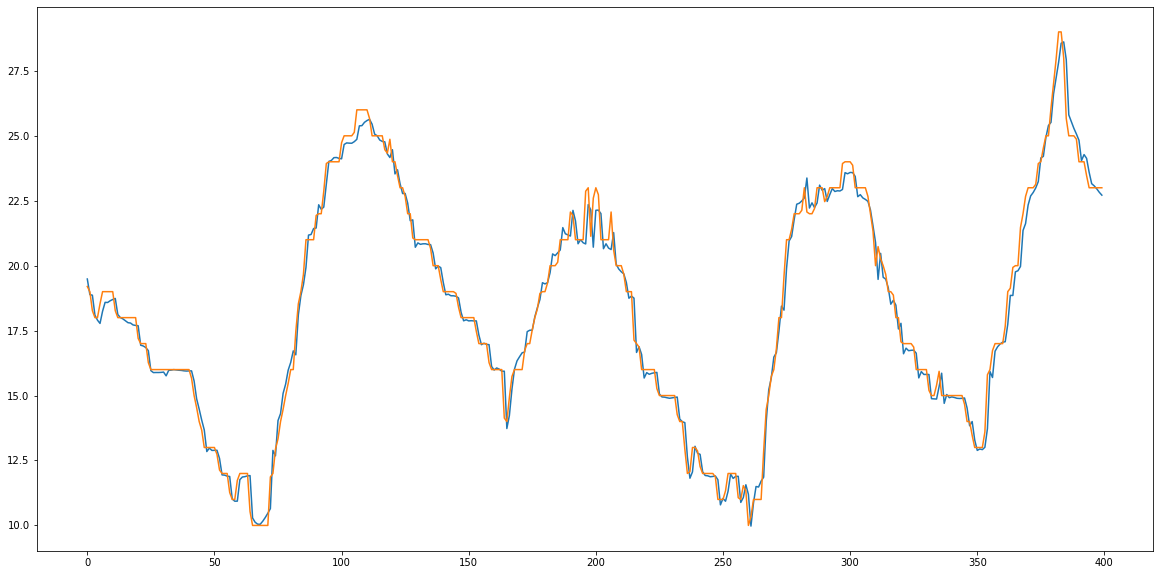

Iter:  211 train:  0.019105779814694086 val:  0.023963294738927037
Iter time:  0.7347062779590487
Iter:  212 train:  0.018246782378788576 val:  0.022998112073024334
Iter time:  0.73822973202914
Saving...
Iter:  213 train:  0.017288803553007406 val:  0.022701766275033102
Iter time:  0.9591644257307053
Iter:  214 train:  0.017728080725684138 val:  0.025715232714203454
Iter time:  0.8222655868157744
Iter:  215 train:  0.020273879971101187 val:  0.02308988155038573
Iter time:  0.8518670117482543
Iter:  216 train:  0.01768711886391777 val:  0.02289938456800114
Iter time:  0.7833564290776849
Iter:  217 train:  0.0175638883542734 val:  0.02444784783132333
Iter time:  0.7346899239346385
Iter:  218 train:  0.018452630451710094 val:  0.022921318382234615
Iter time:  0.731574865989387
Iter:  219 train:  0.017330503373172913 val:  0.023532375986647733
Iter time:  0.7436840310692787
Iter:  220 train:  0.01746275161357235 val:  0.022883571312624976
Iter time:  0.7351258341223001
mse:  0.25345024 mae

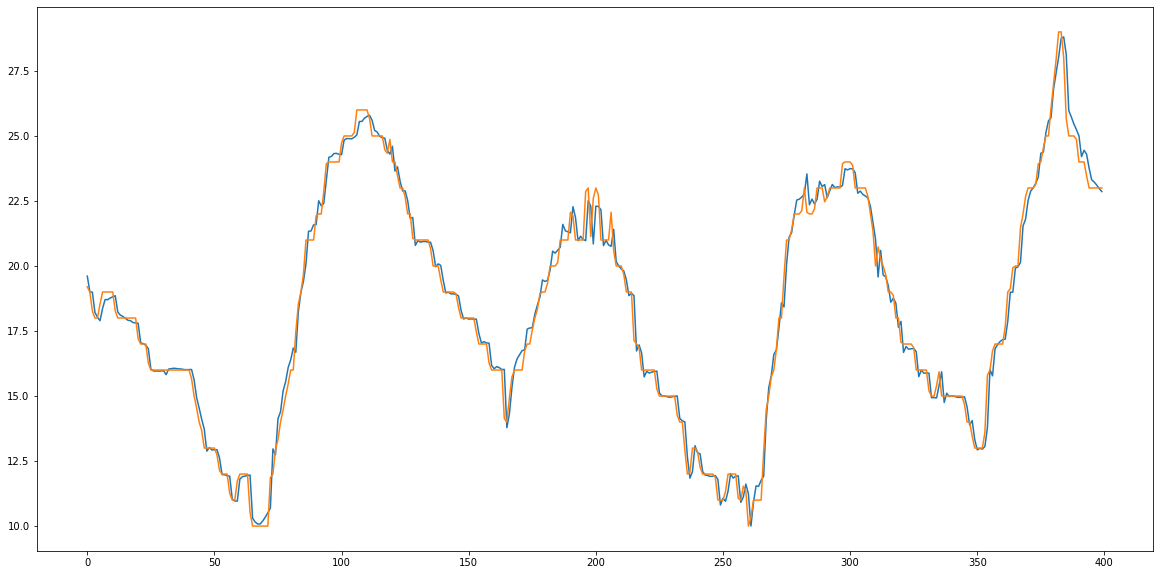

Iter:  221 train:  0.017415065036166587 val:  0.0241250803680051
Iter time:  0.7420523865148425
Iter:  222 train:  0.017522041517657964 val:  0.022783263039213787
Iter time:  0.744295246899128
Iter:  223 train:  0.01753492560691763 val:  0.02413848952381857
Iter time:  0.7441127048805356
Saving...
Iter:  224 train:  0.017524649813457048 val:  0.0226693509099723
Iter time:  0.8781566917896271
Saving...
Iter:  225 train:  0.017567348107531296 val:  0.02262807360078126
Iter time:  0.8851305628195405
Iter:  226 train:  0.017586584921749256 val:  0.024070144718511533
Iter time:  0.7449426399543881
Iter:  227 train:  0.018711369373330615 val:  0.023015000033455777
Iter time:  0.7449993183836341
Iter:  228 train:  0.017507809111505637 val:  0.024034835759200242
Iter time:  0.7430212739855051
Iter:  229 train:  0.017343828439563187 val:  0.02274527037956592
Iter time:  0.7436033776029944
Iter:  230 train:  0.017648805128989233 val:  0.02396243693445928
Iter time:  0.7433925084769726
mse:  0.27

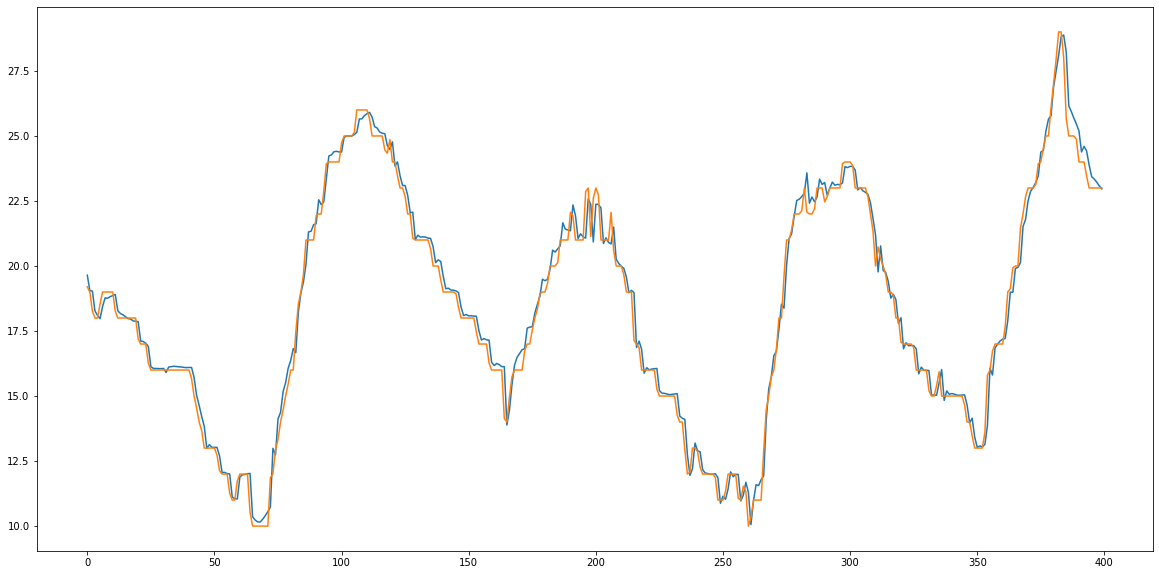

Iter:  231 train:  0.017477209036592684 val:  0.022670272894105697
Iter time:  0.7415418392047286
Iter:  232 train:  0.01793940797975264 val:  0.02298782064580875
Iter time:  0.7431364869698882
Iter:  233 train:  0.0172911395241776 val:  0.02298197549192096
Iter time:  0.7437746524810791
Iter:  234 train:  0.01740528744943493 val:  0.02348547148778005
Iter time:  0.751669954508543
Iter:  235 train:  0.01721006273965272 val:  0.022662740221738743
Iter time:  0.7654098691418767
Iter:  236 train:  0.017690679273876735 val:  0.02354571621969767
Iter time:  0.779815592803061
Iter:  237 train:  0.018140954210294654 val:  0.026911351063185207
Iter time:  0.8987447777763009
Iter:  238 train:  0.018622458728137004 val:  0.02472333746936087
Iter time:  0.9344529043883085
Iter:  239 train:  0.018647275352315668 val:  0.024269825391891833
Iter time:  0.8487345157191157
Iter:  240 train:  0.017564264126516804 val:  0.023221217440539572
Iter time:  0.9281135983765125
mse:  0.2609848 mae:  0.3817532


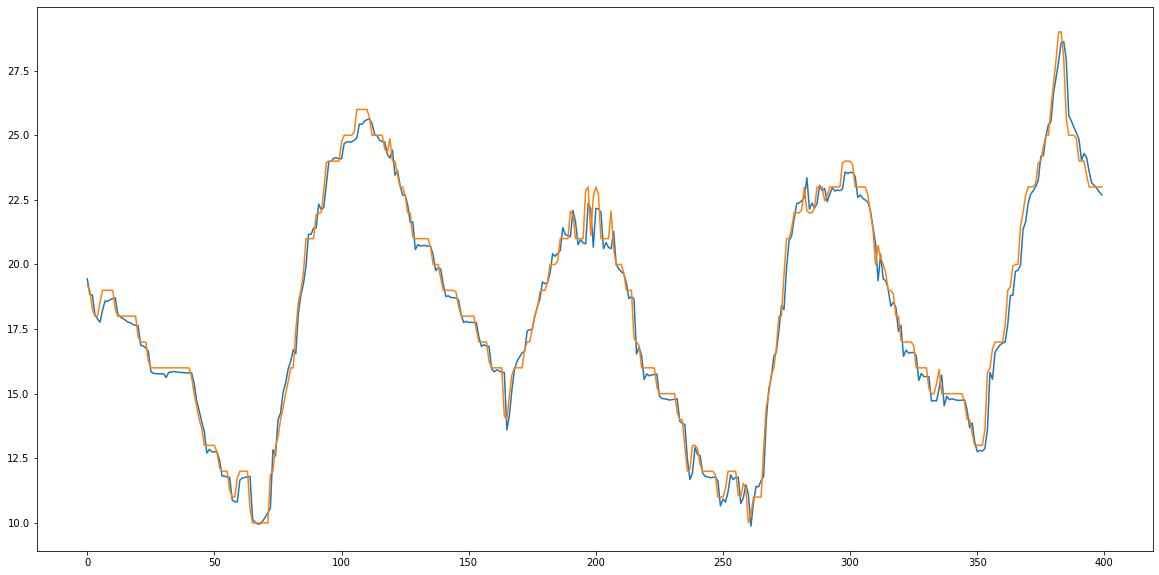

Iter:  241 train:  0.018683129688738358 val:  0.023055438697440915
Iter time:  0.7621587300673127
Iter:  242 train:  0.019170492370731623 val:  0.023276251085814853
Iter time:  0.8127705631777644
Iter:  243 train:  0.01759870280418914 val:  0.02273142158030819
Iter time:  0.9827370243147016
Iter:  244 train:  0.017221807167426707 val:  0.02309998095616623
Iter time:  0.8892849078401923
Iter:  245 train:  0.01755717869034364 val:  0.024260316161323143
Iter time:  0.8053387245163321
Iter:  246 train:  0.018111476665828144 val:  0.022901618066521075
Iter time:  0.8570620808750391
Iter:  247 train:  0.01722225123571267 val:  0.024318226397617
Iter time:  0.9440050413832068
Iter:  248 train:  0.018236815323561188 val:  0.025132549322826696
Iter time:  0.8239092398434877
Iter:  249 train:  0.01791450692010189 val:  0.02293400970676938
Iter time:  0.8259850461035967
Iter:  250 train:  0.01711286127951001 val:  0.02268158907692709
Iter time:  0.7770842919126153
mse:  0.24899593 mae:  0.3480346

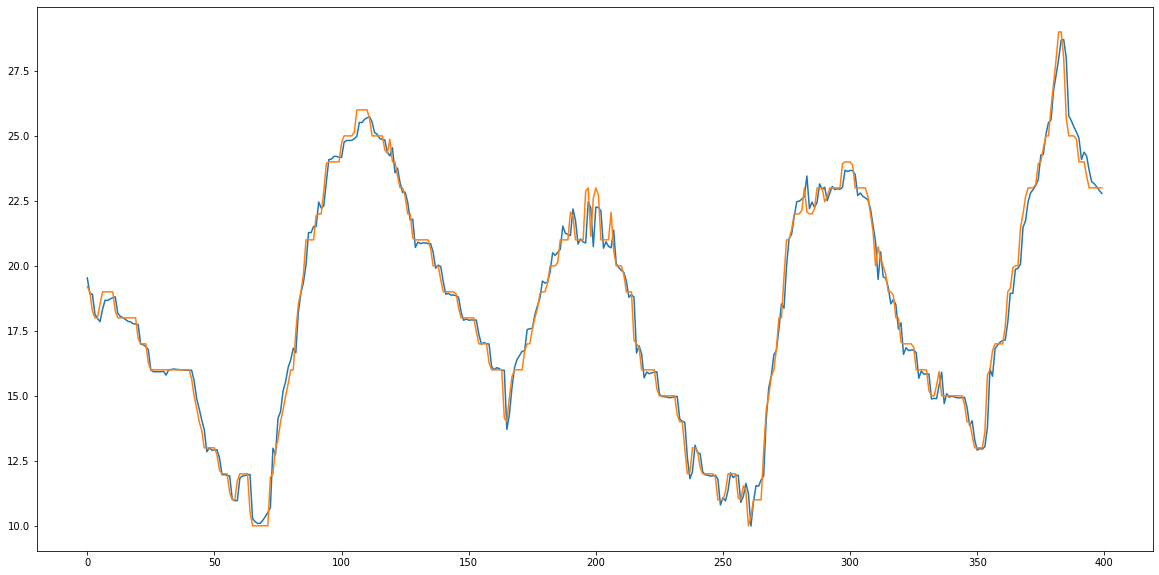

Iter:  251 train:  0.017592906457454264 val:  0.023234676401617912
Iter time:  0.8549107918515801
Iter:  252 train:  0.017487476407952774 val:  0.023399168995773167
Iter time:  0.7937723053619266
Iter:  253 train:  0.017578203649008018 val:  0.026549717425542775
Iter time:  0.9914215849712491
Iter:  254 train:  0.017722617967605103 val:  0.022808404458500634
Iter time:  0.7860811334103346
Iter:  255 train:  0.017187946527880634 val:  0.02279938289265083
Iter time:  0.7418459942564368
Iter:  256 train:  0.017346323533694405 val:  0.022684278292580528
Iter time:  0.7940154140815139
Iter:  257 train:  0.017207367915385893 val:  0.022826867790332918
Iter time:  0.8656640239059925
Iter:  258 train:  0.017441306362783945 val:  0.02394678502782454
Iter time:  0.900061909109354
Iter:  259 train:  0.01782767247128348 val:  0.028461448598875224
Iter time:  0.9892979087308049


In [30]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [31]:
model.load_state_dict(torch.load("imv_lstm_sml2010.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [33]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [34]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [35]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [36]:
mse, mae

(0.13976233, 0.28312695)

In [37]:
mse**0.5

0.3738479999612203

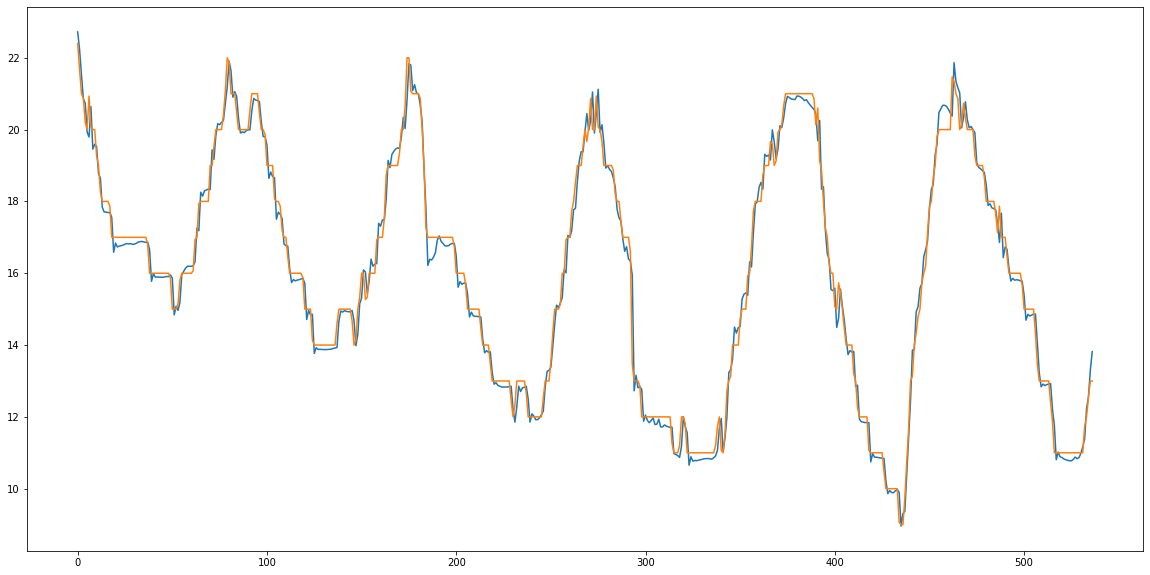

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [39]:
alphas.shape

(537, 10, 17, 1)

In [40]:
betas.shape

(537, 17, 1)

In [41]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [42]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [43]:
alphas = alphas.transpose(1, 0)

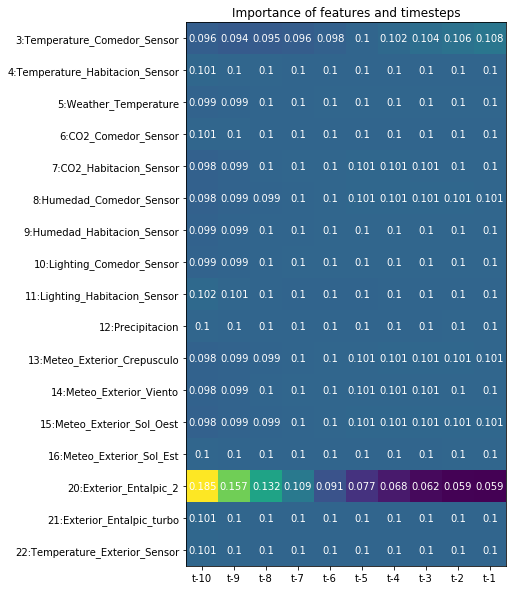

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f57043e9d30>,
 <a list of 17 Text xticklabel objects>)

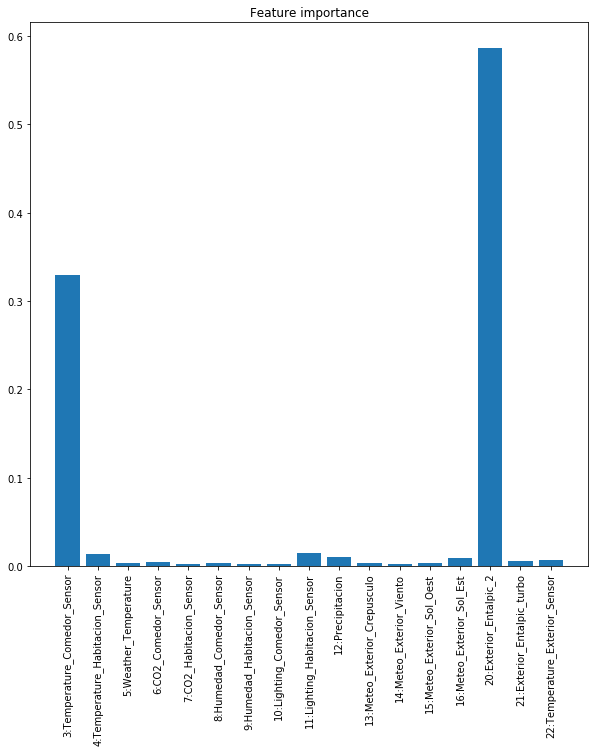

In [45]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)